In [130]:
sh=16
mv=2
ml=4
csh=sh
mvs=[]
for x in range(ml+1):
#     if csh==mv:
#         mvs.append(1)
    
    if x==ml:
        mvs.append(1)
    
    elif csh%mv==0:
        csh=csh/mv
        mvs.append(mv)
        
    elif csh/mv<1:
        if csh>1:
            if csh%int(mv/2)==0:
                csh=csh/(mv/2)

                mvs.append(mv/2)
            else:
                mvs.append(csh/2)
                csh=csh/2

        else:
            csh=csh
            mvs.append(1)        
        
    else:
        csh=csh
        mvs.append(1)
mvs
amvs=[sh/np.product(mvs[:i]) for i in range(len(mvs))]

print(amvs)
print(len(np.where(np.array(mvs)==1)[0]))
assert len(np.where(np.array(mvs)==1)[0])==1

[16.0, 8.0, 4.0, 2.0, 1.0]
1


layer 3 has view of 4 leaving us with 64/4 blocks at this level

layer 2 has view of 4 leaving us with 64/4/4 blocks at this level --> actual manager view is 16

layer 1 has view of 4 leaving us with 64/4/4/4 --> actual manager view  is 64

layer 0 has view of 64/4/4/4/4 --> actual manager view is 256

In [60]:
xc=[4,4,4,4,4]
pov=1
xs=[np.arange(xc1-pov,xc1+pov+2,1) for xc1 in xc]
ys=[np.arange(xc1-pov,xc1+pov+2,1) for xc1 in xc]

In [68]:
xl=[[] for x in xs]
for i,x in enumerate(xs):
    xys[i]=[]
    for xz in x:
        y=ys[i]
        for y1 in y:
            xl[i].append(xz*10+y1)
                

In [69]:
xl

[[33, 34, 35, 36, 43, 44, 45, 46, 53, 54, 55, 56, 63, 64, 65, 66],
 [33, 34, 35, 36, 43, 44, 45, 46, 53, 54, 55, 56, 63, 64, 65, 66],
 [33, 34, 35, 36, 43, 44, 45, 46, 53, 54, 55, 56, 63, 64, 65, 66],
 [33, 34, 35, 36, 43, 44, 45, 46, 53, 54, 55, 56, 63, 64, 65, 66],
 [33, 34, 35, 36, 43, 44, 45, 46, 53, 54, 55, 56, 63, 64, 65, 66]]

In [114]:
import numpy as np
mvs=mvs[::-1]
[np.sum([x*y for  y in mvs[i+1:]]) for i,x in enumerate(mvs)]


[5, 4, 4, 0.0]

In [27]:
4%4

0

In [1]:
from IPython.display import clear_output

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable
from torch.nn import Parameter
from torch.nn import functional as F

from scipy.special import binom

import clingo
import numpy as np

import math
from IPython.display import clear_output

from numpy.random import random_integers as rndint
import pandas as pd
import copy
import random
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

from SimpleMazeNewMarsh1 import *


def get_agent_pov(length, state, env):
    loc = torch.where(state[:, 1, :, :] == 1)
    x_locs = loc[1]
    y_locs = loc[2]
    #     length = 5

    bxl = np.maximum(x_locs - int(length / 2), 0)
    bxu = np.minimum(x_locs + int(length / 2) + 1, env.maze.shape[0])
    byl = np.maximum(y_locs - int(length / 2), 0)
    byu = np.minimum(y_locs + int(length / 2) + 1, env.maze.shape[0])

    current_M = env.get_super_manager_1([x_locs.item(), y_locs.item()])[1]
    for x in range(bxl.item(), bxu.item(), 1):
        for y in range(byl.item(), byu.item(), 1):
            m = env.get_super_manager_1([x, y])[1]

            if current_M == m:
                #             print(x,y)
                # if [x, y] != [x_locs, y_locs]:
                state[:, 1, x, y] = -1

    new_state = state[:, :, bxl:bxu,
                byl:byu]
    if y_locs - (int(length / 2)) < 0:
        s1 = np.minimum(np.abs(y_locs - (int(length / 2))), int(length / 2))
        s2 = 0
    elif (int(length / 2) + y_locs) > env.maze.shape[0] - 1:
        s1 = 0
        cc = np.abs(int(length / 2) + y_locs) + 1 - env.maze.shape[0]

        s2 = np.minimum(int(length / 2) + 1, cc)
    else:
        s1 = 0
        s2 = 0

    if x_locs - (int(length / 2)) < 0:
        s3 = np.minimum(np.abs(x_locs - (int(length / 2))), int(length / 2))
        s4 = 0
    elif (int(length / 2) + x_locs) > env.maze.shape[0] - 1:
        s3 = 0
        cc = np.abs(int(length / 2) + x_locs) + 1 - env.maze.shape[0]
        s4 = np.minimum(cc, int(length / 2) + 1)
    else:
        s3 = 0
        s4 = 0

    #     F.pad(new_state[:, 1, :, :], pad=(s1,s2,s3,s4),
    #                 value=0)
    a_1 = F.pad(new_state[:, 0, :, :], pad=(s1, s2, s3, s4),
                value=1)
    a_2 = F.pad(new_state[:, 1, :, :], pad=(s1, s2, s3, s4),
                value=1)
    blayer = torch.stack((a_1, a_2)).permute(1, 0, 2, 3)
    # print(blayer.size())
    return blayer


def clear():
    os.system('cls')


from collections import defaultdict
from tqdm import tqdm as tqdm


class QNetwork(nn.Module):

    def __init__(self, env, n_input, num_hidden, device, length,man_b):
        nn.Module.__init__(self)
#         num_hidden=50
        self.num_hidden=num_hidden
        self.l1_m = nn.Linear(n_input-8 , num_hidden)
        self.l1_a = nn.Linear(n_input-8 , num_hidden)
        self.device = device
#         self.l2 = nn.Linear(num_hidden, int(num_hidden))
        self.task_layer_m = nn.Linear(5, int(num_hidden))
        self.task_layer_a = nn.Linear(5, int(num_hidden))
        
        
#         if man_b =='Learn':
        self.man_layer = nn.Linear(3, 1)
#         elif man_b =='Init':
#             self.man_layer = nn.Linear(3, 1)
#             self.man_layer.weight=torch.nn.Parameter(torch.tensor([4,2,1],dtype=torch.float).reshape(1,3),requires_grad=True)
#             self.man_layer.bias=torch.nn.Parameter(torch.zeros_like(self.man_layer.bias),requires_grad=False)
#         elif man_b=='Nil':
#             self.man_layer = nn.Linear(3, 1)
#             self.man_layer.weight=torch.nn.Parameter(torch.ones_like(self.man_layer.weight),requires_grad=False)
#             self.man_layer.bias=torch.nn.Parameter(torch.zeros_like(self.man_layer.bias),requires_grad=False)
#         elif man_b=='Exact':
#             self.man_layer = nn.Linear(3, 1)
#             self.man_layer.weight=torch.nn.Parameter(torch.tensor([4,2,1],dtype=torch.float).reshape(1,3),requires_grad=False)
#             self.man_layer.bias=torch.nn.Parameter(torch.zeros_like(self.man_layer.bias),requires_grad=False)
#         else:
#             self.man_layer = nn.Linear(3, 1)
        #         self.l4 = nn.Linear(num_hidden, num_hidden)
#         self.l4 = nn.Linear(int(num_hidden), int(num_hidden))
        self.l3_m = nn.Linear(int(num_hidden), 5)
        self.l3_a = nn.Linear(int(num_hidden), 5)
#         self.conv_1=nn.Conv2d(2,2,kernel_size=3,stride=1)
        #         if length<4:
        #             self.stride_x=4
        #             self.K=4

        #         else:
        #             self.stride_x=2
        self.K = env.maze.shape[0] - length + 1
        self.subsample = nn.AvgPool2d(kernel_size=env.manager_view, stride=env.manager_view, ceil_mode=True)
        self.loc = copy.copy(env.agent_init_state)
        self.length = length
        self.layer_states = {}
        self.current_level = 0
        self.init_super_manager(env)
        self.current_state = self.super_managers[self.current_level]
        self.n_layers = env.n_layers
        self.current_tasks_loc = copy.copy(self.super_managers)
        self.tasks = [env.maze.shape[0] for x in self.current_tasks_loc]
        self.tasks_bools = np.ones(len(self.current_tasks_loc))
        self.hierarchy_actions = [4 for x in range(int(env.n_layers))]
        self.expected_level = 0

        self.lims = self.get_super_manager_1(env, [env.maze.shape[1], env.maze.shape[1]])
        self.search_lims = [env.maze.shape[0] * 1.5 * x[0] for x in self.lims][::-1]
        self.search_lims[-1] = np.maximum(6, self.search_lims[-1])
        self.search_lims[0]=10000000
        # self.blur_layer = BesselConv2d(1, zero_scale=0.25, base=2, n_scales=2)

    #         self.conv_layer =nn.Conv2d(1,1,env.maze.shape[0]-length+1,1)
    #         self.conv_layer.weight=torch.nn.Parameter(torch.ones_like(self.conv_layer.weight),requires_grad=False)
    #         self.conv_layer.bias=torch.nn.Parameter(torch.zeros_like(self.conv_layer.bias),requires_grad=False)
    # man_conv_layer=nn.Conv2d(2,2,4,1)
    # bb=get_agent_pov(5,state,env)

    def reset(self, env):
        self.loc = copy.copy(env.agent_init_state)

        self.layer_states = {}
        self.current_level = 0
        self.init_super_manager(env)
        self.current_state = self.super_managers[self.current_level]

        self.current_tasks_loc = copy.copy(self.super_managers)
        self.tasks = [env.maze.shape[0] for x in self.current_tasks_loc]
        self.tasks_bools = np.ones(len(self.current_tasks_loc))
        self.hierarchy_actions = [4 for x in range(int(env.n_layers))]
        self.expected_level = 0

    def forward(self, x, y, env):
        # try:
        #     x=x[:,:]
        # except:
        #     pass
        l = self.length
        el=env.maze.shape[0]
        if y != self.n_layers:
            #             # x1=self.conv_layer(x[:128].reshape(1,2,8,8))
            # x1=x1.flatten()
            pd = int(self.length / 2)
            mz = x.flatten()[:el**2].reshape(1, 1, el, el)

            aloc = x.flatten()[el**2:2*el**2].reshape(1, 1, el, el)
            # print(aloc)

            mz = self.subsample(mz)
            aloc = self.subsample(aloc)
            mz = F.pad(mz[:
                       , :, :, :], pad=(pd, pd, pd, pd),
                       value=1)

            aloc = F.pad(aloc[:
                         , :, :, :], pad=(pd, pd, pd, pd),
                         value=.1)

            pov = int(l / 2)

            # if torch.sum(aloc).item() > 1:
            #     print('hang on a second')
            _, _, xc, yc = torch.where(aloc == torch.max(aloc))
            # print(aloc)
            # print(xc,yc)
            xc = xc[0]  #
            yc = yc[0]
            mz = mz[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]

            aloc = aloc[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]
            aloc = torch.ceil(aloc - torch.min(aloc))
            aloc[:,:,3,3]=-1
            mz = torch.ceil(mz - torch.min(mz))

            mat_1 = mz.reshape(1, int(l ** 2))

            mat_2 = aloc.reshape(1, int(l ** 2))
            #             print(mat_1)
            #             print(mat_2)
            #             x11=torch.cat((self.conv_layer(x.flatten()[:64].reshape(1,1,8,8)),self.conv_layer(x.flatten()[64:128].reshape(1,1,8,8)).reshape(1,int(l**2))),dim=1)
            # x11 = torch.cat((mat_1, mat_2), dim=1)
            # fig, axs = plt.subplots(4, 4, figsize=(15, 15))
            x11 = torch.stack((mat_1, mat_2)).view(1, 2, 7, 7)
            #             x=torch.cat((x11,x.flatten()[128:].reshape(1,8)),dim=1)
            # torch.stack((self.conv_layer(x[:128].reshape(1,2,8,8)).reshape(50,1).T,x[128:].flatten().reshape(8,1).T))
#             x11=self.conv_1(x11)
            ll=len(x11.to(self.device).flatten())
            out = self.l1_m(x11.to(self.device).flatten().view(1,ll))
            if x.size()[0] == 2*el**2+8:
                x = x.unsqueeze(0)
            task = self.task_layer_m(x[:, 2*el**2+3:].to(self.device))
            out = F.relu(out*task)
        #         out = self.l4(F.relu(out))
            out = self.l3_m(out )
        else:
            state = x.flatten()[:2*el**2].reshape(1, 2, el, el)
            x_1 = get_agent_pov(self.length, state, env)
            #             print(x_1.size())
            # x_1 = x_1[:, 0, :, :]
#             x11 = self.conv_1(x_1)
            ll=len(x_1.to(self.device).flatten())
            out = self.l1_a(x_1.to(self.device).flatten().view(1,ll))
            if x.size()[0] == 2*el**2+8:
                x = x.unsqueeze(0)
            task = self.task_layer_a(x[:, 2*el**2+3:].to(self.device))
            out = F.relu(out*task)
        #         out = self.l4(F.relu(out))
            out = self.l3_a(out )
            # x=torch.cat((self.conv_layer(x[:128].reshape(1,2,8,8)).reshape(1,50),x[128:].flatten().reshape(1,8)),dim=1)
        # torch.cat((x_1,x[128:]))
        #             print(x_1.size())
        #             print(x)
        #             x_1=torch.cat((x_1.reshape(1,int(2*(l**2))),x.flatten()[128:].reshape(1,8)),dim=1)
        #         print(x)
        
#         man = self.man_layer(x[:, 128:131].to(self.device))
        
        #         print(out.size(),man.size(),task.size())

        #         out = self.l2(F.relu(out))
        
#         *man
        return out

    def init_super_manager(self, env):
        n_layers = env.n_layers + 1
        self.super_managers = []
        number_of_levels = n_layers
        self.super_managers.append([np.floor(x / env.manager_view) for x in self.loc])
        if number_of_levels - 2 > 1:
            for i in range(int(number_of_levels - 2)):
                self.super_managers.append([np.floor(x / env.manager_view) for x in self.super_managers[-1]])
        else:
            self.super_managers.append([0, 0])
        self.super_managers = self.super_managers[::-1]

    def get_super_manager_1(self, env, loc):
        #         find which super manager per finest location state
        super_managers = []
        number_of_levels = int(env.n_layers)
        #         super_managers.append([np.floor(x/(2**(number_of_levels-1)/2)) for x in current_state])
        # print(loc)
        super_managers.append([np.floor(x / env.manager_view) for x in loc])
        if number_of_levels - 1 > 1:
            for i in range(number_of_levels - 1):
                super_managers.append([np.floor(x / env.manager_view) for x in super_managers[-1]])
        #                 print(i)
        else:
            super_managers.append([0, 0])
        return super_managers[::-1]

    def get_subs(self, mans, env, level):
        if level == 0:
            subs = []
            for x in range(env.maze.shape[0]):
                for y in range(env.maze.shape[0]):
                    subs.append([x, y])
            #                     index_list.append(x*env.maze.shape[0]+y)
            return np.array([int(x) for x in list(range(env.maze.shape[0] ** 2))]), subs
        else:
            step_view = env.manager_view**(env.n_layers-level)
            xs = []
            ys = []
            #             step_view = 2

            for i in range(0, step_view, 1):
                xs.append(mans[0] * step_view + i)
            for i in range(0, step_view, 1):
                ys.append(mans[1] * step_view + i)
            subs = []
            index_list = []
            for x in xs:
                for y in ys:
                    subs.append([x, y])
                    index_list.append(x * env.maze.shape[0] + y)

            return np.array([int(x) for x in index_list]), subs


def get_epsilon(it):
    # YOUR CODE HERE
    #     raise NotImplementedError

    epsilon = np.maximum(.8 + - .8 * ((it) / 15000), .1)

    #     return epsilon
    return epsilon


class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """

    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon

    def sample_action(self, obs, allowed_actions, i, num_eps, level):
        """
        This method takes a state as input and returns an action sampled from this policy.

        Args:
            obs: current state

        Returns:
            An action (int).

        """
#         if level == 2:
#             eps = np.maximum(self.epsilon, .75 - .75 * (i * 1.15 / num_eps))
#         else:
# #             eps=0.1
        eps =np.maximum(0.05, .35 - .35 * (i * 1.5 / num_eps))
#         eps=0.1
        # YOUR CODE HERE
        #         raise NotImplementedError
        with torch.no_grad():

            # Pytorch can be pretty annoying with its data types!
            state = torch.tensor(obs, dtype=torch.float)

            # get the q values for each action given by the model
            q_sa = self.Q.forward(state, level, env)
            #             print(q_sa)
            # random number to decice each action to take
            choice = torch.rand(1).item()

            if choice < eps:
                # Uniform sampling
                return np.random.choice(allowed_actions), eps

            else:
                # Select the greedy action
                a = allowed_actions[torch.max(q_sa.flatten()[allowed_actions], 0)[1].item()]
                return a, eps

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon


def compute_q_vals(Q, states, ys, env, actions):
    ss=states.clone()
    return Q.forward(ss, ys, env).gather(dim=1, index=actions).squeeze()


def compute_targets(Q, rewards,states, next_states, dones, discount_factor,allowed_actions_current, allowed_actions_next, ys, env,reason):
#     try:
        
#     print(ys)
#     print(ys!=env.n_layers)
    reason=reason[0]
    if ys.item()!=env.n_layers:
        if dones:
            targets=rewards
        else:
        
            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                               [x[1][allowed_actions_next[x[0]]] for x in
                                                                enumerate(Q.forward(next_states, ys, env))]]).reshape(
                len(next_states), 1) * (1 - dones).float()
    else:
        if dones:
            targets = rewards
    #                 TS
        elif reason in [1,3]:
            targets = rewards

    #             TF
#         elif reason==3:
#     #                 man_state=env.get_super_manager_1(ns)[level-1]
#     #                 ms=man_state[0] * self.layer_states[level-1] + man_state[1]
#     #                 task=tasks[level-2]
#     #                 maxq=np.max([self.Q_table[level][ms][task][a] for  a in allowed_future_actions])
#             targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
#                                                            [x[1][allowed_actions_current[x[0]]] for x in
#                                                             enumerate(Q.forward(states, ys, env))]]).reshape(
#             len(states), 1) * (1 - dones).float()
# #         + discount_factor * torch.stack([torch.max(y) for y in
# #                                                            [x[1][allowed_actions_current[x[0]]] for x in
# #                                                             enumerate(Q.forward(states, ys, env))]]).reshape(
# #             len(states), 1) * (1 - dones).float()

    
    # sl
        elif reason==2:

            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                           [x[1][allowed_actions_current[x[0]]] for x in
                                                            enumerate(Q.forward(states, ys, env))]]).reshape(
            len(states), 1) * (1 - dones).float()
# no managerial change
        else:
            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                           [x[1][allowed_actions_next[x[0]]] for x in
                                                            enumerate(Q.forward(next_states, ys, env))]]).reshape(
            len(next_states), 1) * (1 - dones).float()

    
    
    
#     except:
#         print('aaa')
    return targets


class ReplayMemory:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)

        if len(self.memory) > self.capacity:
            self.memory = self.memory[-self.capacity:]

    def sample(self, batch_size):
        idxs = np.random.randint(len(self.memory), size=batch_size)

        return np.array(self.memory)[idxs]

    def __len__(self):
        return len(self.memory)


def train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev, scheduler):
    # DO NOT MODIFY THIS FUNCTION

    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None
    device = torch.device(dev)
    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)

    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done, allowed_actions_next, ys,reason,allowed_actions_current = zip(*transitions)

    # convert to PyTorch and define types
    # state = torch.stack(state).squeeze(1).to(device)
    state = torch.tensor(state, dtype=torch.float).to(device)
    ys = torch.tensor(ys, dtype=torch.float).to(device)
    action = torch.tensor(action, dtype=torch.int64).to(device)[:, None]  # Need 64 bit to use them as index
    # next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(1).to(device)
    next_state = torch.tensor(next_state, dtype=torch.float).to(device)
    reward = torch.tensor(reward, dtype=torch.float).to(device)[:, None]
    done = torch.tensor(done, dtype=torch.uint8).to(device)[:, None]  # Boolean
    # allowed_actions_next=torch.tensor(allowed_actions_next, dtype=torch.int64).to(device)

    # compute the q value
    q_val = compute_q_vals(Q_policy, state, ys, env, action)

    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_targets(Q_target, reward,state, next_state, done, discount_factor,allowed_actions_current, allowed_actions_next, ys, env,reason)
        # print('target', target)
    loss = F.mse_loss(q_val.reshape(batch_size, 1), target)
    # clear()
    # print(env.loc,flush=True)
    # print(loss.item(),flush=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    return loss.item()


# loc_maze=np.zeros((env.maze.shape[0],env.maze.shape[0]))
# loc_maze[Q_policy.loc[0],Q_policy.loc[1]]=1
#
# a=torch.tensor(env.maze)
# b=torch.tensor(loc_maze)
# c=torch.stack((a,b)).float()
# d=a1(c.unsqueeze(0))
# state=c.unsqueeze(0)
#
# # stride
# man_conv_layer=nn.Conv2d(2,2,4,1)
# bb=get_agent_pov(5,state,env)
# man_conv_layer(state).squeeze(0).flatten().detach().numpy()
def print_policy(Q_policy, env, val_1, val_2):
    j = []
    jv = []
    j1v = []
    el = env.maze.shape[0]
    ml = env.manager_view
    em = int(el / ml)
    lisv = []
    sm = []
    man_ag = {}
    for y in range(el):
        for j2 in range(el):
            a = env.get_super_manager_1([y, j2])
            man_ag[y * el + j2] = a[1][0] * 2 + a[1][1]
            if a[-1] not in sm:
                lisv.append(y * el + j2)
                sm.append(a[-1])

    for i, s in enumerate(lisv):
        #     if int(s/8)+s%8<16:

        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        m = 1

        aa = env.possible_actions(m, [int(s / el), s % el])
        loc_idx2, locs = Q_policy.get_subs(sm[i], env, 1)

        t = 4
        state[el ** 2:2 * el ** 2] = 0
        state[el ** 2 + loc_idx2] = 1
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + env.n_layers+1 + t] = 1
        #         print(state)

        j.append(action_dict[aa[torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[1].item()]])
        j1v.append(torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[0].item())
        jv.append([(x, Q_policy.forward(state, 1, env).flatten()[x].item()) for x in aa])
    print(np.array(j).reshape(em, em))
    print(np.array(jv).reshape(em, em))

    j2 = []
    j2v = []
    j22=[]
    value_list = {}
    # lisv=np.sort([2*x for x in range(0,32,8)]+[2*x for x in range(1,33,8)]+[2*x for x in range(2,34,8)]+[2*x for x in range(3,35,8)])
    for s in range(el ** 2):

        #     if int(s/8)+s%8<16:
        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        #         aa=env.possible_actions(m,[int(s/8),s%8])
        state[el ** 2:2 * el ** 2] = val_2
        m = 2
        p = int(man_ag[s])
        # p = int(s / 4) * 2 + int((s / 2) % 4)
        t = action_dict_r[j[p]]
        gm = env.get_super_manager_1([int(s / el), int(s % el)])[1]
        for x in range(el ** 2):
            sm = env.get_super_manager_1([int(x / el), int(x % el)])[1]
            if sm == gm:
                state[el ** 2 + x] = 0

        state[s + el ** 2] = 1
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + 3 + t] = 1
        #         print(p, s, m, t)
        #         print()
        #         print(state)
        if [int(s / el), int(s % el)] == env.goal_init_state:
            j2.append('X')
            j2v.append(0)
            j22.append((s,0))
        elif env.maze[int(s / el), int(s % el)] == 1:
            vv = Q_policy.forward(state, 2, env)
            j2.append('M' + action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
            j22.append((s,vv.flatten()[:4]))
        else:
            vv = Q_policy.forward(state, 2, env)
            value_list[s] = vv.cpu().detach().numpy()
            j2.append(action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
            j22.append((s,vv.flatten()[:4]))
    print(np.array(j2).reshape(el, el
                               ))
    print(np.array(j22))
    print('xxx')

    V = np.array(j1v)
    num_man = int(el / ml)
    cells = [[x, y] for x in range(num_man) for y in range(num_man)]
    policy = np.array(j).reshape(num_man, num_man)

    fig, ax = plt.subplots()
    im = ax.imshow(np.reshape(V, (-1, num_man)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        #     if env.good_cell[cell[0],cell[1]]==1:
        #         text = ax.text(cell[1], cell[0], "Ma",
        #                        ha="center", va="center", color="w")

        if cell == env.get_super_manager_1(env.goal_init_state)[1]:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w")
        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    plt.title('Policy Managerial level')

    plt.show()
    # print('cccc')

    # levlel_2_policy={x:action_map[2][x][t] for x in action_map[2].keys()}
    V = np.array(j2v)
    cells = [[x, y] for x in range(el) for y in range(el)]
    policy = np.array(j2).reshape(el, el)

    fig, ax = plt.subplots()
    V = np.sign(V) * (np.abs(V) ** 0.5)
    im = ax.imshow(np.reshape(V, (-1, el)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        if cell == env.goal_init_state:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w", weight='bold')
        elif env.maze[cell[0], cell[1]] == 1:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]] + '_M',
                           ha="center", va="center", color="w")

        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    fig.set_size_inches(18.5, 10.5)
    plt.title('Policy lower level')
    plt.show()
    print('cccc')


def run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                 min_episodes):
    optimizer = optim.AdamW(Q_policy.parameters(), learn_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01,
                            amsgrad=False)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_episodes, eta_min=0)
    dev = 'cpu'
    global_steps = 0
    losses = []
    rewards = []
    dd = []
    # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    Visit_table = {}
    for l in range(env.n_layers + 1):
        Visit_table[l] = {}
        for s in range(env.maze.shape[0] ** 2):
            Visit_table[l][s] = {}
            for t in range(5):
                Visit_table[l][s][t] = {}
                for a in range(5):
                    Visit_table[l][s][t][a] = 0
    pos_man = 64
    ss=[]
    #     int((env.maze.shape[0]/env.manager_view)**2)
    for i in tqdm(range(num_episodes)):
        
        env.reset()
        ss.append(env.agent_init_state)
        #         Q_policy.loc=copy.copy(env.agent_init_state)
        #         Q_target.loc=copy.copy(env.agent_init_state)
        Q_policy.reset(env)
        Q_target.reset(env)

        #         print('Goal', env.goal_init_state)
        #         print('Agent', Q_policy.loc)
        # agent_row = env.maze.flatten()
        agent_row = copy.copy(env.maze)
        #         agent_row[int(state[0])][int(state[1])] = 1
        #         n_agent_row_1 = np.reshape(agent_row.astype(np.float32), (1, 1, env.maze.shape[0], env.maze.shape[0]))
        #         state = torch.tensor(n_agent_row_1, dtype=torch.float).view(1, 1, env.maze.shape[0], env.maze.shape[0])
        step_counter = 0
        if i > min_episodes:
            if pd.Series(episode_durations).rolling(300).mean().tail(1).values[0] < 4.:
                print('average less than 4.5')
                d = True
            else:
                d = False
                if i > 1000:
                    a = pd.Series(episode_durations).rolling(300).mean() - pd.Series(episode_durations).rolling(
                        300).mean().shift(100)
                    a2  = pd.Series(episode_durations).rolling(300).mean() - pd.Series(episode_durations).rolling(
                        300).mean().expanding().min()
                    if a.abs().rolling(100).mean().tail(1).values[0] < .01:
                        print(a.abs().rolling(100).mean().tail(1).values[0])
                        print('Converged')
                        d = True
                    elif a2.tail(1).values[0] > np.maximum(pd.Series(episode_durations).rolling(300).mean().min(),100):
                        print('Diverged')
                        d = True


#                     elif a.rolling(3).mean().tail(1).values[0] > 1000:
#                         print('Diverged')
#                         d = True

                    else:
                        d = False
#                     if pd.Series(losses).rolling(999).mean().tail(1).values[0]<4:
#                         d=True
        #             if pd.Series(rewards).rolling(100).mean().tail(1).values[0]>-8:
        #                     d=True
        # if pd.Series(episode_durations).rolling(200).mean().tail(1).values[0] - \
        #         pd.Series(episode_durations).rolling(200).mean().shift(-20).dropna().tail(1).values[0] > 30:
        #     d = True

        else:
            d = False
        old_step_counter = 0
        r2 = 0
        #         clear_output(wait=True)

        while d != True:
            # env.current_level=2
            # print('Current position', Q_policy.loc)
            level2 = copy.copy(Q_policy.current_level)
            state_1 = copy.copy(Q_policy.loc)
            current_loc = copy.copy(Q_policy.loc)
            # print(current_loc)
            current_level = copy.copy(Q_policy.current_level)
            allowed_actions = env.possible_actions(current_level, current_loc)

            state = np.zeros(2 * env.maze.shape[0] ** 2 + 8)
            #             if current_level==env.n_layers:
            state[:env.maze.shape[0] ** 2] = env.maze.flatten()
            loc_idx = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
            loc_idx2 = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
            if current_level == 0:
                loc_idx2 = 0

            #                 loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[current_level], env,
            #                                                  current_level)
            elif current_level != env.n_layers:
                #                 loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[current_level], env,
                #                                                  current_level)
                # loc_idx2 = int(current_loc[0] / 2) * 4 + int(current_loc[1] / 2)
                loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc], env, current_level)
            #                 loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
            #                 for jl in loc_idx3:
            #                     state[jl + env.maze.shape[0] ** 2] = .1
            state[loc_idx2 + env.maze.shape[0] ** 2] = 1
            man_idx = int(current_level + 2 * env.maze.shape[0] ** 2)
            state[man_idx] = 1
            cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1

            if current_level != 0:
                task_idx = cc + Q_policy.hierarchy_actions[current_level - 1]
                ttt = Q_policy.hierarchy_actions[current_level - 1]
            else:
                task_idx = cc + 4
                ttt = 4
            state[task_idx] = 1

            if level2 == env.n_layers:
                old_step_counter = step_counter
                step_counter = step_counter + 1
                global_steps = global_steps + 1

            epsilon = get_epsilon(global_steps)
            epg = EpsilonGreedyPolicy(Q_policy, epsilon)
            if current_level == 0:
                a = 4
            else:
                a, eps = epg.sample_action(state, allowed_actions, i, num_episodes, level2)
            # print('Action', allowed_actions, a)
            #             env.check_dicts[0][current_level][a] += 1
            if current_level == env.n_layers:
                Visit_table[current_level][loc_idx2][ttt][a] += 1
            elif current_level == env.n_layers - 1:
                loc_level = int(current_loc[0] / 2) * 4 + int(current_loc[1] / 2)
                Visit_table[current_level][loc_level][ttt][a] += 1
            ns, d = env.step(a, current_level, Q_policy)
            #             print(current_loc,a,ns)
            nl = copy.copy(Q_policy.current_level)
            # print('NewState', ns)
            # print('New level', Q_policy.current_level)
            #             print('----------------------------------------')
            #             print('Goal:', i, env.goal_init_state)
            #             print(current_loc, current_level)
            #             print(allowed_actions, a)
            #             print(ns, Q_policy.current_level)
            #             print('----------------------------------------')
            Q_policy.loc = copy.copy(ns)
            if step_counter > 1:
                if Q_policy.current_level != 0:
                    env.checks_if_level_should_change(state_1, ns, Q_policy.current_level, d, Q_policy,False)
                else:
                    Q_policy.expected_level = copy.copy(Q_policy.current_level)
            else:
                Q_policy.expected_level = copy.copy(Q_policy.current_level)

            old_reset = copy.copy(env.reset_reward)
            #             if current_level==2:
            #                 print(env.reset_reward,env.reset_reward_2)

            r = env.reward(Q_policy, d, current_level)
            #             if current_level==2:
            #                 print(r)
            if d == True:
                env.reset_reward = [5 for x in env.reset_reward]

            n_agent_row = np.zeros(2 * env.maze.shape[0] ** 2 + 8)
            #             if current_level == env.n_layers:
            n_agent_row[:env.maze.shape[0] ** 2] = env.maze.flatten()
            loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
            loc_idx2 = int(env.maze.shape[0] * ns[0] + ns[1])
            if Q_policy.expected_level == 0:
                loc_idx2 = 0
            #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
            #                                                   Q_policy.expected_level)
            elif Q_policy.expected_level != env.n_layers:
                rf = env.manager_view ** (env.n_layers - current_level)
                loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in ns], env, current_level)
                
#                 loc_idx2 = int(ns[0] / 2) * 4 + int(ns[1] / 2)
            #                 loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
            #                 for jl in loc_idx3:
            #                     n_agent_row[jl + env.maze.shape[0] ** 2] = .10
            #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
            #                                                   Q_policy.expected_level)
            #             print(loc_idx2)
            n_agent_row[env.maze.shape[0] ** 2 + loc_idx2] = 1
            man_idx = int(Q_policy.expected_level + 2 * env.maze.shape[0] ** 2)
            n_agent_row[man_idx] = 1
            if nl != 0:
                task_idx = cc + Q_policy.hierarchy_actions[Q_policy.expected_level - 1]
            else:
                task_idx = cc + 4
            n_agent_row[task_idx] = 1
            #             print('-ll-')
            #             print(state)
            #             print(n_agent_row)
            for x in enumerate(old_reset):
                level = x[0]
                x = x[1]
                reason=x
                allowed_actions_next = env.possible_actions(level, ns)
                #                 env.get_possible_actions(ns, level)
                allowed_actions_current= env.possible_actions(level, state_1)
                if level2 == env.n_layers:
                    r2 += r[-1]
                    if level == env.n_layers:
                        
                        assert allowed_actions_next == [0, 1, 2, 3]
                        memory.push((state, a, r[level], n_agent_row, d, allowed_actions_next, level,reason,allowed_actions_current))
                        loss = train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev, scheduler)
                        losses.append(loss)
                    else:

                        if x not in [0]:
                            if level not in [env.n_layers, 0]:
                                # print(ns,level)
                                if env.get_super_manager_1(ns)[level] == env.get_super_manager_1(env.goal_init_state)[
                                    level]:
                                    # try:
                                    if env.search_clause == True:
                                        allowed_actions_next == [4]

                                else:
                                    if env.search_clause == True:
                                        assert all(a in [0, 1, 2, 3, ] for a in allowed_actions_next)
                                    else:
                                        assert all(a in [0, 1, 2, 3, 4] for a in allowed_actions_next)

                                state_ll = np.zeros(2 * env.maze.shape[0] ** 2 + 8)
                                #                             loc_idx = int(env.maze.shape[0] * state_l[0] + state_l[1])
                                state_ll[:env.maze.shape[0] ** 2] = env.maze.flatten()
                                if level == 0:
                                    loc_idx2 = 0
                                #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                #                                                                      level)
                                elif level == 1:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)
                                    # loc_idx2 = int(state_1[0] / env.manager_view) * 4 + int(
                                    #     state_1[1] / env.manager_view)
                                    rf = env.manager_view ** (env.n_layers - level)
                                    loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in current_loc], env,
                                                                       level)
#                                     loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc],
#                                                                        env, current_level)
                                #                                     loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
                                #                                     for jl in loc_idx3:
                                #                                         state_ll[jl + env.maze.shape[0] ** 2] = .1
                                state_ll[loc_idx2 + env.maze.shape[0] ** 2] = 1
                                man_idx = int(level + 2 * env.maze.shape[0] ** 2)
                                state_ll[man_idx] = 1
                                if level != 0:
                                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                                    task_idx = cc + Q_policy.hierarchy_actions[level - 1]
                                else:
                                    task_idx = cc + 4
                                state_ll[task_idx] = 1

                                n_agent_row_ll = np.zeros(2 * env.maze.shape[0] ** 2 + 8)
                                #                             loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
                                n_agent_row_ll[:env.maze.shape[0] ** 2] = env.maze.flatten()
                                if level != 0:
                                    level3 = level - 1
                                else:
                                    level3 = 0
                                if level == 0:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)

                                    loc_idx2 = 0
                                elif level == 1:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)
                                    # loc_idx2 = int(ns[0] / env.manager_view) * 4 + int(ns[1] / env.manager_view)
                                    rf = env.manager_view ** (env.n_layers - level)
                                    loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in Q_policy.loc ], env,
                                                                       level)

                                
                                
#                                 loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc],
#                                                                        env, current_level)
                                #                                     loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
                                #                                     for jl in loc_idx3:
                                #                                         n_agent_row_ll[jl + env.maze.shape[0] ** 2] = .1
                                n_agent_row_ll[loc_idx2 + env.maze.shape[0] ** 2] = 1

                                man_idx = int(level + 2 * env.maze.shape[0] ** 2)
                                n_agent_row_ll[man_idx] = 1
                                if level != 0:
                                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                                    task_idx = cc + Q_policy.hierarchy_actions[level3]
                                else:
                                    task_idx = cc + 4
                                n_agent_row_ll[task_idx] = 1
                                #                                 print('ll')
                                #                                 print(state_ll)
                                #                                 print(n_agent_row_ll)

                                #                         update q values
                                memory.push((state_ll, a, r[level], n_agent_row_ll, d, allowed_actions_next, level,reason,allowed_actions_current))
                                loss = train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev,
                                             scheduler)
                                losses.append(loss)

            #             n_agent_row = np.reshape(n_agent_row.astype(np.float32), (1, 1, env.maze.shape[0], env.maze.shape[0]))
            #             n_agent_row = torch.tensor(n_agent_row, dtype=torch.float).view(1, 1, env.maze.shape[0], env.maze.shape[0])
            state = n_agent_row
            Q_policy.current_level = copy.copy(Q_policy.expected_level)
            Q_target.current_level = copy.copy(Q_policy.expected_level)
            Q_target.loc = copy.copy(Q_policy.loc)
            Q_target.expected_level = copy.copy(Q_policy.expected_level)
            Q_target.current_tasks_loc = copy.copy(Q_policy.current_tasks_loc)
            Q_target.tasks = copy.copy(Q_policy.tasks)
            Q_target.tasks_bools = copy.copy(Q_policy.tasks_bools)
            Q_target.hierarchy_actions = copy.copy(Q_policy.hierarchy_actions)

            if d != True:
                env.reset_rewards_after_learning(old_reset)

            if step_counter > 5000:
                print('diverged')
                break
            if d:
                episode_durations.append(step_counter)
                rewards.append(r2)
                break
            #             if step_counter > 500:
            #                 if step_counter % 50:
            #                     print(current_loc,ns,a)
            #             if step_counter> 20*(env.maze.shape[0]**2) :
            #                 print('TMS')
            #                 break

            #             Q_target = soft_update(Q_policy, Q_target, tau=1e-3)
            Q_target = copy.copy(Q_policy)
        if i % 50 == 0:
            #                 print(env.check_dicts)
            #                 print(env.loc)
            if i%300:
                print_policy(Q_policy, env, 0, 0)
            if i%400:
                clear_output(wait=True)
            print('epsilon', eps)
            if i > 300:
                dd.append(pd.Series(episode_durations).rolling(300).mean().min())
                print(dd)
                print('min mean', pd.Series(episode_durations).rolling(300).mean().min())
                print('last mean', pd.Series(episode_durations).rolling(300).mean().tail(1))
    #             Q_talastrget.load_state_dict
    #             Q_target.load_state_dict(Q_policy.state_dict())
    return episode_durations, losses, Visit_table, rewards,ss


def soft_update(local_model, target_model, tau):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
    return target_model

# env=Normal_Maze(22)

action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




# import matplotlib.pyplot as plt



# env = Hierarchical_Maze(8, 2, 2, 2, False,True,2,True,0)
# # env=Normal_Maze(22)
# print(env.goal_init_state)
# print(env.maze)
# plt.imshow(env.maze)
# results = {}
# counter = 0
# env.goal_init_state=[0,0]


# # results = {}
# counter = 0
# # length=7
# # env = Hierarchical_Maze(16, 2, 4, 2,True)
# num_episodes = 8000
# batch_size = 1
# discount_factor = 0.95
# learn_rate = 1e-3
# seed = 100
# random.seed(seed)
# torch.manual_seed(seed)
# r_dict_3={}

# device = torch.device("cpu")

# for length in [7]:
# #     for num_hidden in  [int(n_input*1.1)]:
# # counter=0
#     n_input = 2*length ** 2 + 8

#     for num_hidden in  [int(length ** 2)]:
# #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
# #     for length in [3]:
#         memory = ReplayMemory(1)



#         Q_policy = QNetwork(env, n_input, num_hidden, device,length).to(device)
#         Q_target = QNetwork(env, n_input, num_hidden, device,length).to(device)

#         # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
#         # Q_target = QNetwork(n_input, num_hidden, device).to(device)

#         # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
#         # target_net = DQN(screen_height, screen_width, n_actions).to(device)
#         Q_target.load_state_dict(Q_policy.state_dict())
#         Q_target.eval()
#         allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

#         policy = EpsilonGreedyPolicy(Q_policy, 0.08)

#         episode_durations, losses, Visit_table,rewards = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
#                                                               batch_size,
#                                                               discount_factor, learn_rate, np.minimum(500,num_episodes))
#         r_dict_3[counter]={'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
#                          'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
#         counter=counter+1
# #         import matplotlib.pyplot as plt
# #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






[6, 3]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


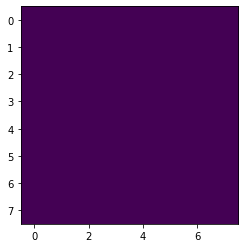

In [14]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




import matplotlib.pyplot as plt



env = Hierarchical_Maze(8
                        , 2, 2, 2, False,False,2,False,0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
env.goal_init_state=[4,4]



In [9]:
pp=nn.AvgPool2d(kernel_size=4, stride=4, ceil_mode=True)

In [10]:
em=torch.tensor(env.maze.reshape(1,1,16,16))

ValueError: cannot reshape array of size 64 into shape (1,1,16,16)

In [6]:
torch.ceil(pp(em)-pp(em).min())

tensor([[[[0., 0., 0., 0.],
          [0., 1., 0., 1.],
          [0., 0., 1., 1.],
          [0., 1., 1., 1.]]]], dtype=torch.float64)

In [15]:

# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
num_episodes = 4000
batch_size = 1
discount_factor =1
learn_rate = 1e-4
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)
r_dict_3={}

device = torch.device("cpu")
for man_init in ['Learn']:
    for length in [7]:
    #     for num_hidden in  [int(n_input*1.1)]:
    # counter=0
        n_input = 2*length ** 2 + 8

        for num_hidden in  [int(2*length ** 2)]:
    #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
    #     for length in [3]:
            memory = ReplayMemory(1)



            Q_policy = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)
            Q_target = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)

            # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
            # Q_target = QNetwork(n_input, num_hidden, device).to(device)

            # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
            # target_net = DQN(screen_height, screen_width, n_actions).to(device)
            Q_target.load_state_dict(Q_policy.state_dict())
            Q_target.eval()
            allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

            policy = EpsilonGreedyPolicy(Q_policy, 0.08)

            episode_durations, losses, Visit_table,rewards,ss = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                                  batch_size,
                                                                  discount_factor, learn_rate, np.minimum(500,num_episodes))
            r_dict_3[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                             'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
            counter=counter+1
    #         import matplotlib.pyplot as plt
    #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






 99%|█████████████████████████████████████████████████████████████████████████████ | 3952/4000 [09:19<00:18,  2.58it/s]

epsilon 0.05
[19.323333333333334, 10.41, 9.713333333333333, 9.336666666666666, 9.336666666666666, 8.996666666666666, 8.87, 8.773333333333333, 8.576666666666666, 8.576666666666666, 8.576666666666666, 8.576666666666666, 8.576666666666666, 8.576666666666666, 8.576666666666666, 8.336666666666666, 8.093333333333334, 7.706666666666667, 7.283333333333333, 6.88, 6.763333333333334, 6.466666666666667, 6.383333333333334, 6.383333333333334, 6.383333333333334, 6.383333333333334, 6.383333333333334, 6.383333333333334, 6.383333333333334, 6.29, 6.29, 6.23, 6.01, 5.843333333333334, 5.683333333333334, 5.626666666666667, 5.466666666666667, 5.43, 5.4, 5.336666666666667, 5.286666666666667, 5.286666666666667, 5.153333333333333, 5.056666666666667, 4.946666666666666, 4.946666666666666, 4.94, 4.843333333333334, 4.843333333333334, 4.843333333333334, 4.843333333333334, 4.843333333333334, 4.843333333333334, 4.843333333333334, 4.843333333333334, 4.843333333333334, 4.843333333333334, 4.843333333333334, 4.84333333333

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [09:24<00:00,  7.09it/s]


C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:566: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['S' 'S' 'S' 'S']
 ['E' 'S' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'W']]
[[list([(0, -8.491703987121582), (1, -5.868107318878174), (2, -6.220641613006592), (3, -7.897739410400391)])
  list([(0, -7.811189651489258), (1, -3.9582111835479736), (2, -5.212457180023193), (3, -6.707947254180908)])
  list([(0, -6.027291297912598), (1, -2.023430824279785), (2, -5.573145866394043), (3, -4.8971476554870605)])
  list([(0, -6.976607322692871), (1, -3.619694948196411), (2, -5.9722490310668945), (3, -4.389700889587402)])]
 [list([(0, -7.272960662841797), (1, -4.565751552581787), (2, -4.419620037078857), (3, -6.983062267303467)])
  list([(0, -5.762451648712158), (1, -2.148913621902466), (2, -2.794964551925659), (3, -4.993260860443115)])
  list([(0, -3.0944876670837402), (1, 0.22345824539661407), (2, -3.492964267730713), (3, -2.4182047843933105)])
  list([(0, -5.197870254516602), (1, -1.777729868888855), (2, -4.203041076660156), (3, -2.0092484951019287)])]
 [list([(0, -5.467008590698242), (1, 

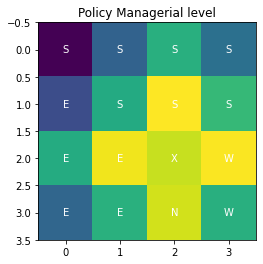

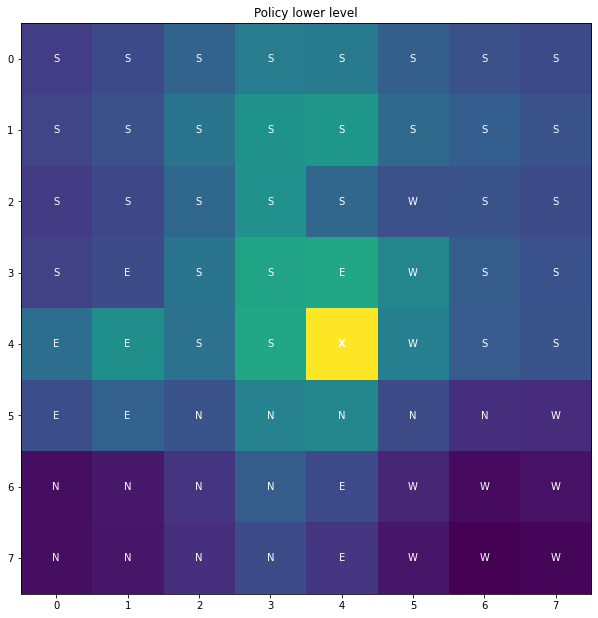

cccc


In [16]:
print_policy(Q_policy, env, 0, 0)

[['S' 'S' 'S' 'S']
 ['S' 'S' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'N']]
[[list([(0, -8.381664276123047), (1, -5.7280988693237305), (2, -6.027668476104736), (3, -8.279838562011719)])
  list([(0, -7.388933181762695), (1, -4.1725358963012695), (2, -4.977219581604004), (3, -7.169499397277832)])
  list([(0, -5.765286445617676), (1, -2.767709970474243), (2, -5.1003804206848145), (3, -5.584925651550293)])
  list([(0, -6.338541507720947), (1, -4.026843547821045), (2, -5.583429336547852), (3, -5.077584266662598)])]
 [list([(0, -7.017448425292969), (1, -4.378950595855713), (2, -4.38007926940918), (3, -7.157819747924805)])
  list([(0, -5.004426002502441), (1, -2.010416269302368), (2, -2.578681230545044), (3, -5.100054740905762)])
  list([(0, -2.4975974559783936), (1, -0.10599993914365768), (2, -2.6754274368286133), (3, -2.7475407123565674)])
  list([(0, -3.962845802307129), (1, -2.256150245666504), (2, -3.89756441116333), (3, -2.441239595413208)])]
 [list([(0, -5.323702812194824), (1, -

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



xxx


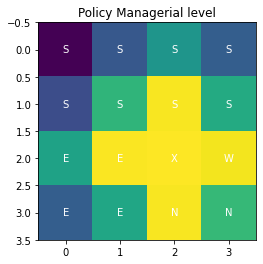

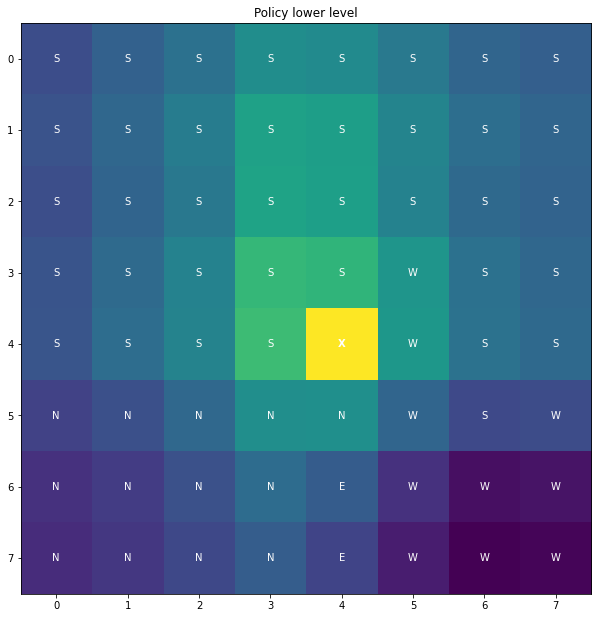

cccc


In [12]:
j = []
jv = []
j1v = []
val_1=0
val_2=0
el = env.maze.shape[0]
ml = env.manager_view
em = int(el / ml)
lisv = []
sm = []
man_ag = {}
for y in range(el):
    for j2 in range(el):
        a = env.get_super_manager_1([y, j2])
        man_ag[y * el + j2] = a[1][0] * 2 + a[1][1]
        if a[-1] not in sm:
            lisv.append(y * el + j2)
            sm.append(a[-1])

for i, s in enumerate(lisv):
    #     if int(s/8)+s%8<16:

    state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
    state[:el ** 2] = torch.tensor(env.maze.flatten())
    m = 1

    aa = env.possible_actions(m, [int(s / el), s % el])
    loc_idx2, locs = Q_policy.get_subs(sm[i], env, 1)

    t = 4
    state[el ** 2:2 * el ** 2] = 0
    state[el ** 2 + loc_idx2] = 1
    state[2 * el ** 2 + m] = 1
    state[2 * el ** 2 + env.n_layers+1 + t] = 1
    #         print(state)

    j.append(action_dict[aa[torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[1].item()]])
    j1v.append(torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[0].item())
    jv.append([(x, Q_policy.forward(state, 1, env).flatten()[x].item()) for x in aa])
print(np.array(j).reshape(em, em))
print(np.array(jv).reshape(em, em))

j2 = []
j2v = []
j22=[]
value_list = {}
# lisv=np.sort([2*x for x in range(0,32,8)]+[2*x for x in range(1,33,8)]+[2*x for x in range(2,34,8)]+[2*x for x in range(3,35,8)])
for s in range(el ** 2):

    #     if int(s/8)+s%8<16:
    state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
    state[:el ** 2] = torch.tensor(env.maze.flatten())
    #         aa=env.possible_actions(m,[int(s/8),s%8])
    state[el ** 2:2 * el ** 2] = val_2
    m = 2
    p = int(man_ag[s])
    # p = int(s / 4) * 2 + int((s / 2) % 4)
    t = action_dict_r[j[p]]
    gm = env.get_super_manager_1([int(s / el), int(s % el)])[1]
    for x in range(el ** 2):
        sm = env.get_super_manager_1([int(x / el), int(x % el)])[1]
        if sm == gm:
            state[el ** 2 + x] = 0

    state[s + el ** 2] = 1
    state[2 * el ** 2 + m] = 1
    state[2 * el ** 2 + 3 + t] = 1
    #         print(p, s, m, t)
    #         print()
    #         print(state)
    if [int(s / el), int(s % el)] == env.goal_init_state:
        j2.append('X')
        j2v.append(0)
        j22.append((s,0))
    elif env.maze[int(s / el), int(s % el)] == 1:
        vv = Q_policy.forward(state, 2, env)
        j2.append('M' + action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
        j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
        j22.append((s,vv.flatten()[:4]))
    else:
        vv = Q_policy.forward(state, 2, env)
        value_list[s] = vv.cpu().detach().numpy()
        j2.append(action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
        j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
        j22.append((s,vv.flatten()[:4]))
print(np.array(j2).reshape(el, el
                           ))
print(np.array(j22))
print('xxx')

V = np.array(j1v)
num_man = int(el / ml)
cells = [[x, y] for x in range(num_man) for y in range(num_man)]
policy = np.array(j).reshape(num_man, num_man)

fig, ax = plt.subplots()
im = ax.imshow(np.reshape(V, (-1, num_man)))
for cell in cells:
    #     p = cell.getCoords()
    #     i = cell.getIndex()
    #     if not cell.isGoal():
    #         text = ax.text(p[1], p[0], str(policy[i]),
    #                    ha="center", va="center", color="w")
    #     if env.good_cell[cell[0],cell[1]]==1:
    #         text = ax.text(cell[1], cell[0], "Ma",
    #                        ha="center", va="center", color="w")

    if cell == env.get_super_manager_1(env.goal_init_state)[1]:
        text = ax.text(cell[1], cell[0], "X",
                       ha="center", va="center", color="w")
    else:
        text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                       ha="center", va="center", color="w")
plt.title('Policy Managerial level')

plt.show()
# print('cccc')

# levlel_2_policy={x:action_map[2][x][t] for x in action_map[2].keys()}
V = np.array(j2v)
cells = [[x, y] for x in range(el) for y in range(el)]
policy = np.array(j2).reshape(el, el)

fig, ax = plt.subplots()
V = np.sign(V) * (np.abs(V) ** 0.5)
im = ax.imshow(np.reshape(V, (-1, el)))
for cell in cells:
    #     p = cell.getCoords()
    #     i = cell.getIndex()
    #     if not cell.isGoal():
    #         text = ax.text(p[1], p[0], str(policy[i]),
    #                    ha="center", va="center", color="w")
    if cell == env.goal_init_state:
        text = ax.text(cell[1], cell[0], "X",
                       ha="center", va="center", color="w", weight='bold')
    elif env.maze[cell[0], cell[1]] == 1:
        text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]] + '_M',
                       ha="center", va="center", color="w")

    else:
        text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                       ha="center", va="center", color="w")
fig.set_size_inches(18.5, 10.5)
plt.title('Policy lower level')
plt.show()
print('cccc')

In [52]:
# Q_policy.l3.weight.size()

In [35]:
pd.Series(losses).rolling(1000).mean()

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
96931    12.916915
96932    12.921987
96933    12.922661
96934    12.922664
96935    12.934175
Length: 96936, dtype: float64

In [42]:
pd.Series(episode_durations).rolling(100).mean()

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
8443    4.99
8444    4.99
8445    4.94
8446    4.93
8447    4.90
Length: 8448, dtype: float64

In [37]:
pd.Series(losses).rolling(999).mean().tail(1).values[0]

12.947121872427402

In [38]:
import collections

In [39]:
a=collections.Counter([tuple(x) for x in ss])

<AxesSubplot:>

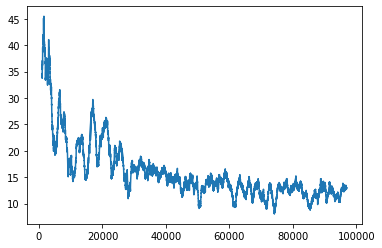

In [40]:
pd.Series(losses).rolling(1000).mean().plot()

In [13]:
Q_policy

QNetwork(
  (l1_m): Linear(in_features=98, out_features=98, bias=True)
  (l1_a): Linear(in_features=98, out_features=98, bias=True)
  (task_layer_m): Linear(in_features=5, out_features=98, bias=True)
  (task_layer_a): Linear(in_features=5, out_features=98, bias=True)
  (man_layer): Linear(in_features=3, out_features=1, bias=True)
  (l3_m): Linear(in_features=98, out_features=5, bias=True)
  (l3_a): Linear(in_features=98, out_features=5, bias=True)
  (subsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [14]:
Q_policy.man_layer.bias

#

Parameter containing:
tensor([0.4307], requires_grad=True)

In [15]:
Q_policy.man_layer.weight


Parameter containing:
tensor([[0.4657, 0.0069, 0.3961]], requires_grad=True)

In [16]:
for i in range(3):
    x=torch.zeros(3)
    x[i]=1
#     ([0.,0.,1.]
    print(Q_policy.man_layer(x))


tensor([0.8964], grad_fn=<AddBackward0>)
tensor([0.4375], grad_fn=<AddBackward0>)
tensor([0.8267], grad_fn=<AddBackward0>)


In [17]:
pd.Series(episode_durations).rolling(100).mean().idxmin()

8485

In [18]:
Q_policy

QNetwork(
  (l1_m): Linear(in_features=98, out_features=98, bias=True)
  (l1_a): Linear(in_features=98, out_features=98, bias=True)
  (task_layer_m): Linear(in_features=5, out_features=98, bias=True)
  (task_layer_a): Linear(in_features=5, out_features=98, bias=True)
  (man_layer): Linear(in_features=3, out_features=1, bias=True)
  (l3_m): Linear(in_features=98, out_features=5, bias=True)
  (l3_a): Linear(in_features=98, out_features=5, bias=True)
  (subsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [15]:
PATH = "C:/Users/howar/AppData/Local/Programs/netron"
torch.save(Q_policy.state_dict(), os.path.join(PATH,"filename.pth"))

In [24]:
val_2=0
val_1=0

el = env.maze.shape[0]


man_ag = {}
j = {}
jv = {}
j1v = {}
for level in range(env.n_layers):
    
    ml = env.manager_view**(env.n_layers-level)
    em = int(el / ml)
    
    print(level)
    man_ag[level]={}
    lisv = []
    sm = []
    for y in range(el):
        for j2 in range(el):
            a = env.get_super_manager_1([y, j2])

    #          a is manager e.g. 3,3
    #  what's the equivalent for manager to pass when getting task

            man_ag[level][y * el + j2] = a[level][0] * (el/env.manager_view**(env.n_layers-level)) + a[level][1]
            if a[level] not in sm:
                lisv.append(y * el + j2)
                sm.append(a[level])
    print(lisv)
    print(sm)
    j[level] = []
    jv[level] = []
    j1v[level] = []
    for i, s in enumerate(lisv):
        #     if int(s/8)+s%8<16:

        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        m = level

        aa = env.possible_actions(m, [int(s / el), s % el])
        loc_idx2, locs = Q_policy.get_subs(sm[i], env, level)
        if level==0:
            t=4
            
        else:
            p = int(man_ag[level-1][s])
        # p = int(s / 4) * 2 + int((s / 2) % 4)
            t = action_dict_r[j[level-1][p]]
        
        state[el ** 2:2 * el ** 2] = 0
        state[el ** 2 + loc_idx2] = 1
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + env.n_layers+1 + t] = 1
        #         print(state)

        j[level].append(action_dict[aa[torch.max(Q_policy.forward(state, level, env).flatten()[aa], axis=0)[1].item()]])
        j1v[level].append(torch.max(Q_policy.forward(state, level, env).flatten()[aa], axis=0)[0].item())
        jv[level].append([(x, Q_policy.forward(state, level, env).flatten()[x].item()) for x in aa])
    if level!=0:
        print(np.array(j[level]).reshape(em, em))
        print(np.array(jv[level]).reshape(em, em))
j2 = []
j2v = []
value_list = {}
for s in range(el ** 2):

    #     if int(s/8)+s%8<16:
    state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
    state[:el ** 2] = torch.tensor(env.maze.flatten())
    #         aa=env.possible_actions(m,[int(s/8),s%8])
#     state[el ** 2:2 * el ** 2] = val_2
    m = env.n_layers
#     this is used to find task
    p = int(man_ag[env.n_layers-1][s])
    # p = int(s / 4) * 2 + int((s / 2) % 4)
    t = action_dict_r[j[env.n_layers-1][p]]
#     print(s,p,t)
#     gm = env.get_super_manager_1([int(s / el), int(s % el)])[env.n_layers-1]
#     for x in range(el ** 2):
#         sm = env.get_super_manager_1([int(x / el), int(x % el)])[env.n_layers-1]
#         if sm == gm:
#             state[el ** 2 + x] = 0

    state[s + el ** 2] = 1
    state[2 * el ** 2 + m] = 1
    state[2 * el ** 2 + env.n_layers+1 + t] = 1
    #         print(p, s, m, t)
    #         print()
    #         print(state)
    if [int(s / el), int(s % el)] == env.goal_init_state:
        j2.append('X')
        j2v.append(0)
    elif env.maze[int(s / el), int(s % el)] == 1:
        vv = Q_policy.forward(state, env.n_layers, env)
        j2.append('M' + action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
        j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
    else:
        vv = Q_policy.forward(state, env.n_layers, env)
        value_list[s] = vv.cpu().detach().numpy()
        j2.append(action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
        j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
print(np.array(j2).reshape(el, el
                           ))
print('xxx')

0
[0]
[[0, 0]]
1
[0, 2, 4, 6, 16, 18, 20, 22, 32, 34, 36, 38, 48, 50, 52, 54]
[[0.0, 0.0], [0.0, 1.0], [0.0, 2.0], [0.0, 3.0], [1.0, 0.0], [1.0, 1.0], [1.0, 2.0], [1.0, 3.0], [2.0, 0.0], [2.0, 1.0], [2.0, 2.0], [2.0, 3.0], [3.0, 0.0], [3.0, 1.0], [3.0, 2.0], [3.0, 3.0]]
[['S' 'S' 'S' 'S']
 ['E' 'E' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'W']]
[[list([(0, -24.82961082458496), (1, -15.85758113861084), (2, -16.376453399658203), (3, -21.15984344482422)])
  list([(0, -22.743114471435547), (1, -13.660178184509277), (2, -14.28158187866211), (3, -19.133920669555664)])
  list([(0, -17.855812072753906), (1, -10.495912551879883), (2, -14.679104804992676), (3, -15.141227722167969)])
  list([(0, -20.098737716674805), (1, -13.02817153930664), (2, -16.43979835510254), (3, -16.619426727294922)])]
 [list([(0, -22.317764282226562), (1, -13.298227310180664), (2, -13.15956974029541), (3, -18.664846420288086)])
  list([(0, -17.889659881591797), (1, -9.638113975524902), (2, -9.331258773803711), (3, 

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


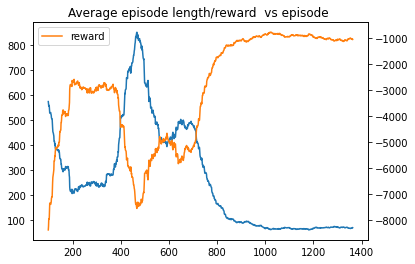

In [32]:

pd.Series(episode_durations).rolling(100).mean().plot(label='episode duration')
pd.Series(rewards).rolling(100).mean().plot(secondary_y=True,label='reward')
plt.title('Average episode length/reward  vs episode ')
plt.legend()

In [8]:
pd.Series(episode_durations).rolling(100).mean().idxmin()

4296

In [9]:
pd.Series(episode_durations).rolling(100).mean().min()

4.92

In [12]:
pd.Series(rewards).rolling(100).mean().max()

-40.74

In [13]:
pd.Series(rewards).rolling(100).mean().idxmax()

4741

In [14]:
a=pd.Series(rewards).rolling(100).mean()-pd.Series(rewards).rolling(100).mean().shift(-100)

In [15]:
a.tail(3000).idxmin()

2001

<AxesSubplot:>

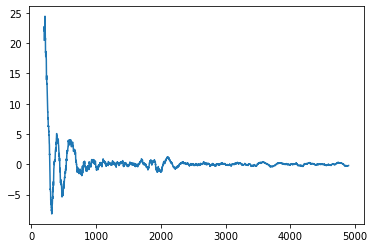

In [16]:
a.diff().rolling(100).mean().plot()

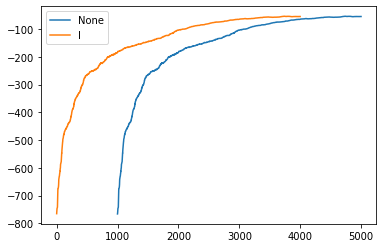

In [17]:
pd.Series(rewards).rolling(1000).mean().plot()
pd.Series(rewards).rolling(1000).mean().shift(-1000).plot(label='l')
plt.legend()

In [18]:
pd.Series(rewards).rolling(100).mean().max()

-40.74

In [19]:
pd.Series(rewards).rolling(50).mean()

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
4995   -59.88
4996   -59.94
4997   -60.66
4998   -60.00
4999   -60.12
Length: 5000, dtype: float64

In [20]:
Q_policy.man_layer.weight

Parameter containing:
tensor([[0.4657, 0.0069, 0.3961]], requires_grad=True)

In [30]:
val_2=0
val_1=0

el = env.maze.shape[0]


man_ag = {}
j = {}
jv = {}
j1v = {}
for level in range(env.n_layers):
    
    ml = env.manager_view**(env.n_layers-level)
    em = int(el / ml)
    
    print(level)
    man_ag[level]={}
    lisv = []
    sm = []
    for y in range(el):
        for j2 in range(el):
            a = env.get_super_manager_1([y, j2])

    #          a is manager e.g. 3,3
    #  what's the equivalent for manager to pass when getting task

            man_ag[level][y * el + j2] = a[level][0] * (el/env.manager_view**(env.n_layers-level)) + a[level][1]
            if a[level] not in sm:
                lisv.append(y * el + j2)
                sm.append(a[level])
    print(lisv)
    print(sm)
    j[level] = []
    jv[level] = []
    j1v[level] = []
    for i, s in enumerate(lisv):
        #     if int(s/8)+s%8<16:

        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        m = level

        aa = env.possible_actions(m, [int(s / el), s % el])
        loc_idx2, locs = Q_policy.get_subs(sm[i], env, level)
        if level==0:
            t=4
            
        else:
            p = int(man_ag[level-1][s])
        # p = int(s / 4) * 2 + int((s / 2) % 4)
            t = action_dict_r[j[level-1][p]]
        
        state[el ** 2:2 * el ** 2] = 0
        state[el ** 2 + loc_idx2] = 1
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + env.n_layers+1 + t] = 1
        #         print(state)

        j[level].append(action_dict[aa[torch.max(Q_policy.forward(state, level, env).flatten()[aa], axis=0)[1].item()]])
        j1v[level].append(torch.max(Q_policy.forward(state, level, env).flatten()[aa], axis=0)[0].item())
        jv[level].append([(x, Q_policy.forward(state, level, env).flatten()[x].item()) for x in aa])
    if level!=0:
        print(np.array(j[level]).reshape(em, em))
        print(np.array(jv[level]).reshape(em, em))
j2 = []
j2v = []
value_list = {}
for s in range(el ** 2):

    #     if int(s/8)+s%8<16:
    state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
    state[:el ** 2] = torch.tensor(env.maze.flatten())
    #         aa=env.possible_actions(m,[int(s/8),s%8])
#     state[el ** 2:2 * el ** 2] = val_2
    m = env.n_layers
#     this is used to find task
    p = int(man_ag[env.n_layers-1][s])
    # p = int(s / 4) * 2 + int((s / 2) % 4)
    t = action_dict_r[j[env.n_layers-1][p]]
#     print(s,p,t)
#     gm = env.get_super_manager_1([int(s / el), int(s % el)])[env.n_layers-1]
#     for x in range(el ** 2):
#         sm = env.get_super_manager_1([int(x / el), int(x % el)])[env.n_layers-1]
#         if sm == gm:
#             state[el ** 2 + x] = 0

    state[s + el ** 2] = 1
    state[2 * el ** 2 + m] = 1
    state[2 * el ** 2 + env.n_layers+1 + t] = 1
    #         print(p, s, m, t)
    #         print()
    #         print(state)
    if [int(s / el), int(s % el)] == env.goal_init_state:
        j2.append('X')
        j2v.append(0)
    elif env.maze[int(s / el), int(s % el)] == 1:
        vv = Q_policy.forward(state, env.n_layers, env)
        j2.append('M' + action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
        j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
    else:
        vv = Q_policy.forward(state, env.n_layers, env)
        value_list[s] = vv.cpu().detach().numpy()
        j2.append(action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
        j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
print(np.array(j2).reshape(el, el
                           ))
print('xxx')

0
[0]
[[0, 0]]
1
[0, 4, 8, 12, 64, 68, 72, 76, 128, 132, 136, 140, 192, 196, 200, 204]
[[0.0, 0.0], [0.0, 1.0], [0.0, 2.0], [0.0, 3.0], [1.0, 0.0], [1.0, 1.0], [1.0, 2.0], [1.0, 3.0], [2.0, 0.0], [2.0, 1.0], [2.0, 2.0], [2.0, 3.0], [3.0, 0.0], [3.0, 1.0], [3.0, 2.0], [3.0, 3.0]]
[['S' 'S' 'S' 'W']
 ['E' 'Search' 'W' 'W']
 ['E' 'N' 'N' 'W']
 ['N' 'N' 'N' 'N']]
[[list([(0, -13.717729568481445), (1, -6.724488258361816), (2, -9.043379783630371), (3, -13.687029838562012)])
  list([(0, -8.774868965148926), (1, -2.8968708515167236), (2, -10.795371055603027), (3, -9.72360610961914)])
  list([(0, -14.066728591918945), (1, -6.7252302169799805), (2, -16.732711791992188), (3, -8.980205535888672)])
  list([(0, -19.152772903442383), (1, -13.323845863342285), (2, -20.89417839050293), (3, -12.796149253845215)])]
 [list([(0, -9.7789945602417), (1, -10.827507019042969), (2, -1.91475510597229), (3, -7.3144426345825195)])
  list([(4, 0.13384759426116943)])
  list([(0, -9.93606185913086), (1, -11.006996154

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['E' 'E' 'E' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'W' 'S' 'S']
 ['E' 'E' 'E' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'W' 'W' 'W']
 ['E' 'E' 'E' 'S' 'S' 'W' 'S' 'S' 'S' 'W' 'S' 'S' 'S' 'N' 'N' 'N']
 ['E' 'E' 'W' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'N' 'W' 'W' 'W']
 ['E' 'E' 'E' 'E' 'X' 'W' 'W' 'W' 'E' 'W' 'W' 'W' 'E' 'W' 'W' 'S']
 ['E' 'N' 'N' 'E' 'N' 'W' 'W' 'W' 'N' 'N' 'N' 'W' 'N' 'N' 'W' 'S']
 ['N' 'E' 'E' 'E' 'N' 'W' 'W' 'W' 'N' 'N' 'N' 'W' 'N' 'N' 'N' 'W']
 ['E' 'E' 'E' 'E' 'N' 'N' 'W' 'W' 'N' 'W' 'W' 'W' 'N' 'W' 'W' 'W']
 ['E' 'E' 'E' 'E' 'S' 'W' 'W' 'W' 'S' 'W' 'W' 'W' 'E' 'W' 'W' 'S']
 ['E' 'N' 'N' 'E' 'S' 'W' 'W' 'N' 'S' 'W' 'W' 'N' 'N' 'N' 'W' 'S']
 ['N' 'E' 'E' 'E' 'N' 'W' 'W' 'N' 'N' 'W' 'W' 'N' 'N' 'N' 'N' 'W']
 ['E' 'E' 'E' 'E' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W' 'W' 'W']
 ['E' 'E' 'E' 'W' 'S' 'W' 'W' 'W' 'S' 'W' 'W' 'W' 'S' 'W' 'W' 'W']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W' 'W' 'W']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W' 'N' 